In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
!pip install opencv-python
import cv2
!pip install albumentations
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
IMAGE_PATH = '/Users/indrajitkar/Downloads/semantic_drone_dataset/original_images/'
MASK_PATH = '/Users/indrajitkar/Downloads/semantic_drone_dataset/label_images_semantic/'

In [ ]:
print(os.listdir(IMAGE_PATH))

['162.jpg', '176.jpg', '348.jpg', '406.jpg', '412.jpg', '228.jpg', '214.jpg', '572.jpg', '566.jpg', '200.jpg', '016.jpg', '002.jpg', '003.jpg', '567.jpg', '215.jpg', '573.jpg', '229.jpg', '598.jpg', '413.jpg', '375.jpg', '361.jpg', '349.jpg', '177.jpg', '163.jpg', '188.jpg', '149.jpg', '175.jpg', '161.jpg', '388.jpg', '439.jpg', '411.jpg', '363.jpg', '559.jpg', '565.jpg', '217.jpg', '001.jpg', '015.jpg', '014.jpg', '000.jpg', '028.jpg', '570.jpg', '216.jpg', '202.jpg', '564.jpg', '558.jpg', '376.jpg', '410.jpg', '438.jpg', '389.jpg', '160.jpg', '174.jpg', '148.jpg', '170.jpg', '164.jpg', '158.jpg', '414.jpg', '372.jpg', '366.jpg', '428.jpg', '560.jpg', '206.jpg', '574.jpg', '004.jpg', '038.jpg', '011.jpg', '005.jpg', '549.jpg', '213.jpg', '561.jpg', '207.jpg', '429.jpg', '367.jpg', '373.jpg', '398.jpg', '159.jpg', '165.jpg', '171.jpg', '198.jpg', '167.jpg', '173.jpg', '403.jpg', '588.jpg', '563.jpg', '239.jpg', '013.jpg', '006.jpg', '238.jpg', '204.jpg', '576.jpg', '416.jpg', '172.jpg'

In [ ]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


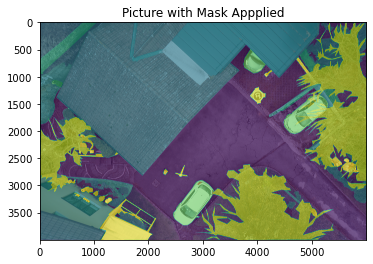

In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

In [ ]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size=3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
# Code
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.5f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.5f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.5f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.5f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.5f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.5f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.3f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.3f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.683 
Epoch:1/50.. Train Loss: 3.14658.. Val Loss: 2.68324.. Train mIoU:0.01244.. Val mIoU: 0.03814.. Train Acc:0.03774.. Val Acc:0.18623.. Time: 6.433m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.683 >> 2.063 
Epoch:2/50.. Train Loss: 2.57318.. Val Loss: 2.06319.. Train mIoU:0.06012.. Val mIoU: 0.10431.. Train Acc:0.26762.. Val Acc:0.57615.. Time: 6.416m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.063 >> 1.693 
Epoch:3/50.. Train Loss: 2.13332.. Val Loss: 1.69279.. Train mIoU:0.08926.. Val mIoU: 0.10033.. Train Acc:0.51397.. Val Acc:0.59111.. Time: 6.961m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.693 >> 1.451 
saving model...
Epoch:4/50.. Train Loss: 1.77719.. Val Loss: 1.45057.. Train mIoU:0.09685.. Val mIoU: 0.10815.. Train Acc:0.56011.. Val Acc:0.62552.. Time: 7.210m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.451 >> 1.398 
Epoch:5/50.. Train Loss: 1.57281.. Val Loss: 1.39755.. Train mIoU:0.10358.. Val mIoU: 0.12212.. Train Acc:0.58349.. Val Acc:0.63185.. Time: 7.332m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.398 >> 1.266 
Epoch:6/50.. Train Loss: 1.56857.. Val Loss: 1.26592.. Train mIoU:0.09945.. Val mIoU: 0.11837.. Train Acc:0.55978.. Val Acc:0.66207.. Time: 7.223m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/50.. Train Loss: 1.43567.. Val Loss: 1.32113.. Train mIoU:0.11257.. Val mIoU: 0.11161.. Train Acc:0.59018.. Val Acc:0.61221.. Time: 7.305m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.321 >> 1.151 
Epoch:8/50.. Train Loss: 1.42444.. Val Loss: 1.15122.. Train mIoU:0.11389.. Val mIoU: 0.14096.. Train Acc:0.58350.. Val Acc:0.68263.. Time: 7.268m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/50.. Train Loss: 1.33644.. Val Loss: 1.24280.. Train mIoU:0.12524.. Val mIoU: 0.13761.. Train Acc:0.60585.. Val Acc:0.60472.. Time: 7.348m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.243 >> 1.188 
Epoch:10/50.. Train Loss: 1.30720.. Val Loss: 1.18765.. Train mIoU:0.13349.. Val mIoU: 0.13254.. Train Acc:0.61468.. Val Acc:0.62224.. Time: 7.274m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.188 >> 1.126 
saving model...
Epoch:11/50.. Train Loss: 1.30807.. Val Loss: 1.12646.. Train mIoU:0.13101.. Val mIoU: 0.14382.. Train Acc:0.60704.. Val Acc:0.66497.. Time: 7.266m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.126 >> 1.093 
Epoch:12/50.. Train Loss: 1.25898.. Val Loss: 1.09300.. Train mIoU:0.14358.. Val mIoU: 0.15341.. Train Acc:0.62245.. Val Acc:0.67082.. Time: 7.277m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:13/50.. Train Loss: 1.22732.. Val Loss: 1.09409.. Train mIoU:0.15076.. Val mIoU: 0.16783.. Train Acc:0.63138.. Val Acc:0.68880.. Time: 7.211m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.094 >> 1.049 
Epoch:14/50.. Train Loss: 1.20616.. Val Loss: 1.04888.. Train mIoU:0.15689.. Val mIoU: 0.17405.. Train Acc:0.63766.. Val Acc:0.68259.. Time: 7.238m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.049 >> 0.970 
Epoch:15/50.. Train Loss: 1.16561.. Val Loss: 0.96984.. Train mIoU:0.16783.. Val mIoU: 0.18201.. Train Acc:0.64899.. Val Acc:0.70617.. Time: 7.184m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:16/50.. Train Loss: 1.13043.. Val Loss: 1.08943.. Train mIoU:0.17245.. Val mIoU: 0.18576.. Train Acc:0.65879.. Val Acc:0.63972.. Time: 7.368m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.089 >> 1.032 
Epoch:17/50.. Train Loss: 1.10436.. Val Loss: 1.03243.. Train mIoU:0.18620.. Val mIoU: 0.18687.. Train Acc:0.66426.. Val Acc:0.66349.. Time: 7.355m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.032 >> 0.918 
saving model...
Epoch:18/50.. Train Loss: 1.07751.. Val Loss: 0.91828.. Train mIoU:0.19357.. Val mIoU: 0.21836.. Train Acc:0.67925.. Val Acc:0.72234.. Time: 27.267m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:19/50.. Train Loss: 1.04266.. Val Loss: 1.02064.. Train mIoU:0.20514.. Val mIoU: 0.20088.. Train Acc:0.68154.. Val Acc:0.67660.. Time: 9.118m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.021 >> 0.970 
Epoch:20/50.. Train Loss: 1.01977.. Val Loss: 0.96992.. Train mIoU:0.20557.. Val mIoU: 0.21094.. Train Acc:0.68848.. Val Acc:0.67752.. Time: 7.364m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.970 >> 0.922 
Epoch:21/50.. Train Loss: 1.02739.. Val Loss: 0.92171.. Train mIoU:0.20971.. Val mIoU: 0.21378.. Train Acc:0.68849.. Val Acc:0.70801.. Time: 57.888m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.922 >> 0.859 
Epoch:22/50.. Train Loss: 1.03316.. Val Loss: 0.85904.. Train mIoU:0.20669.. Val mIoU: 0.23653.. Train Acc:0.68946.. Val Acc:0.74444.. Time: 22.403m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:23/50.. Train Loss: 0.96867.. Val Loss: 0.86724.. Train mIoU:0.22243.. Val mIoU: 0.22088.. Train Acc:0.70229.. Val Acc:0.73434.. Time: 23.712m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.867 >> 0.835 
Epoch:24/50.. Train Loss: 0.95565.. Val Loss: 0.83518.. Train mIoU:0.22822.. Val mIoU: 0.23531.. Train Acc:0.71315.. Val Acc:0.73762.. Time: 8.452m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 286.660 m


In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

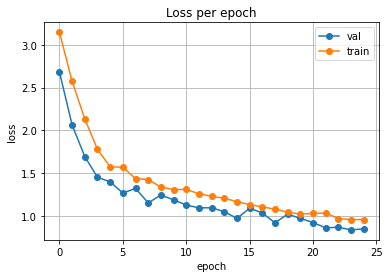

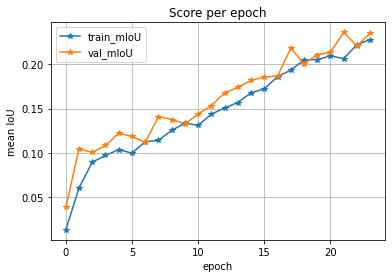

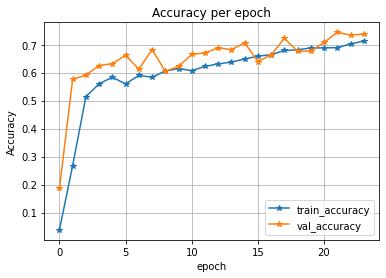

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history1 = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.897 
Epoch:1/50.. Train Loss: 1.01147.. Val Loss: 0.89701.. Train mIoU:0.22741.. Val mIoU: 0.23902.. Train Acc:0.69502.. Val Acc:0.72483.. Time: 2.158m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.897 >> 0.848 
Epoch:2/50.. Train Loss: 0.88514.. Val Loss: 0.84803.. Train mIoU:0.24390.. Val mIoU: 0.25685.. Train Acc:0.73414.. Val Acc:0.73949.. Time: 2.155m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/50.. Train Loss: 0.85739.. Val Loss: 0.85966.. Train mIoU:0.24970.. Val mIoU: 0.25898.. Train Acc:0.73802.. Val Acc:0.73816.. Time: 2.161m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/50.. Train Loss: 0.83792.. Val Loss: 0.89376.. Train mIoU:0.25359.. Val mIoU: 0.23856.. Train Acc:0.74987.. Val Acc:0.73092.. Time: 2.163m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.894 >> 0.857 
Epoch:5/50.. Train Loss: 0.84314.. Val Loss: 0.85745.. Train mIoU:0.24971.. Val mIoU: 0.25621.. Train Acc:0.74459.. Val Acc:0.72778.. Time: 2.163m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:6/50.. Train Loss: 0.89916.. Val Loss: 0.86335.. Train mIoU:0.23737.. Val mIoU: 0.25056.. Train Acc:0.72362.. Val Acc:0.72967.. Time: 2.164m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:7/50.. Train Loss: 0.90836.. Val Loss: 0.88132.. Train mIoU:0.24669.. Val mIoU: 0.25537.. Train Acc:0.73033.. Val Acc:0.72903.. Time: 2.163m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:8/50.. Train Loss: 0.85340.. Val Loss: 0.88327.. Train mIoU:0.24726.. Val mIoU: 0.26059.. Train Acc:0.74046.. Val Acc:0.72921.. Time: 2.167m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.883 >> 0.871 
saving model...
Epoch:9/50.. Train Loss: 0.93426.. Val Loss: 0.87112.. Train mIoU:0.23929.. Val mIoU: 0.25256.. Train Acc:0.72115.. Val Acc:0.72943.. Time: 2.161m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:10/50.. Train Loss: 0.94138.. Val Loss: 0.91493.. Train mIoU:0.23745.. Val mIoU: 0.23720.. Train Acc:0.71305.. Val Acc:0.72801.. Time: 2.164m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 23.852 m


In [ ]:
torch.save(model, 'Unet-Mobilenet1.pt')

In [ ]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history1 = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.451 
Epoch:1/50.. Train Loss: 2.83202.. Val Loss: 2.45065.. Train mIoU:0.03691.. Val mIoU: 0.06057.. Train Acc:0.23557.. Val Acc:0.41051.. Time: 2.669m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.451 >> 2.120 
Epoch:2/50.. Train Loss: 2.30264.. Val Loss: 2.12028.. Train mIoU:0.07078.. Val mIoU: 0.07996.. Train Acc:0.46519.. Val Acc:0.51506.. Time: 2.551m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.120 >> 1.755 
Epoch:3/50.. Train Loss: 1.95939.. Val Loss: 1.75466.. Train mIoU:0.08277.. Val mIoU: 0.08201.. Train Acc:0.51962.. Val Acc:0.54690.. Time: 2.529m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.755 >> 1.708 
saving model...
Epoch:4/50.. Train Loss: 1.69286.. Val Loss: 1.70800.. Train mIoU:0.10004.. Val mIoU: 0.10222.. Train Acc:0.56951.. Val Acc:0.58137.. Time: 2.514m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.708 >> 1.412 
Epoch:5/50.. Train Loss: 1.54241.. Val Loss: 1.41207.. Train mIoU:0.10794.. Val mIoU: 0.11431.. Train Acc:0.57999.. Val Acc:0.62662.. Time: 2.451m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/50.. Train Loss: 1.43632.. Val Loss: 1.44197.. Train mIoU:0.11806.. Val mIoU: 0.11529.. Train Acc:0.60166.. Val Acc:0.60514.. Time: 2.477m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.442 >> 1.387 
Epoch:7/50.. Train Loss: 1.40586.. Val Loss: 1.38729.. Train mIoU:0.12114.. Val mIoU: 0.11894.. Train Acc:0.60476.. Val Acc:0.61056.. Time: 2.518m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/50.. Train Loss: 1.38000.. Val Loss: 1.40047.. Train mIoU:0.12038.. Val mIoU: 0.11621.. Train Acc:0.60093.. Val Acc:0.59057.. Time: 2.511m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.400 >> 1.210 
Epoch:9/50.. Train Loss: 1.29018.. Val Loss: 1.20985.. Train mIoU:0.13514.. Val mIoU: 0.14595.. Train Acc:0.63186.. Val Acc:0.65101.. Time: 2.599m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/50.. Train Loss: 1.30251.. Val Loss: 1.29521.. Train mIoU:0.13861.. Val mIoU: 0.14125.. Train Acc:0.61747.. Val Acc:0.60675.. Time: 2.622m


  0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

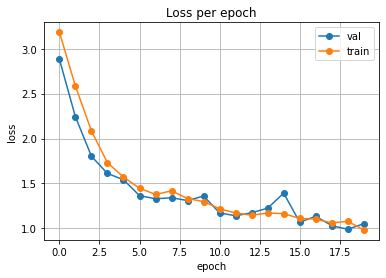

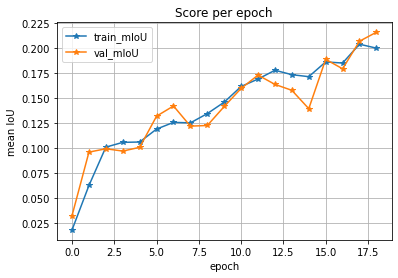

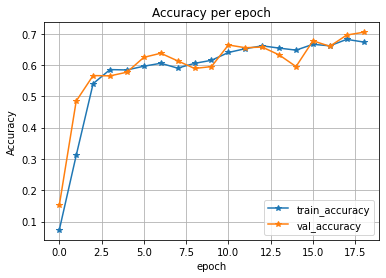

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

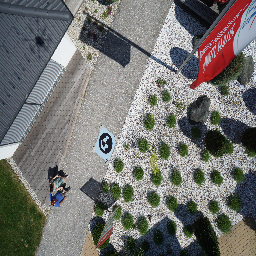

In [ ]:
image

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)
mob_miou

  0%|          | 0/40 [00:00<?, ?it/s]

[0.009725966325582905,
 0.01713851964632886,
 0.03095746586899435,
 0.020571615157723353,
 0.0010564945469724296,
 0.023814862839906074,
 0.016621638838386243,
 0.016142107071385213,
 0.03400291257101331,
 0.03220147100749854,
 0.002760774466191602,
 0.027349629167907556,
 0.056987986870299934,
 0.015799387442916337,
 0.06910323290576813,
 0.02924041462480026,
 0.026887944867299698,
 0.020296261008432875,
 0.02499841979809471,
 0.01622308592898228,
 0.017040705102707967,
 0.036963884634827346,
 0.030881449955948236,
 0.010168482143429082,
 0.019926409023042515,
 0.04780355873948184,
 0.05955055488265926,
 0.00299101007713517,
 0.013092971850272191,
 0.02040611602660802,
 0.013407138686909273,
 0.017650491941873507,
 0.01651924305334753,
 0.039452637696464066,
 0.01285844137811732,
 0.03013100674871002,
 0.017318668715000502,
 0.033926834423455926,
 0.03447251532839869,
 0.054856278145501425]

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.02553246473770936
